### Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./DeepRacerCar.png)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml

sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_docker_image
from docker_utils import push as docker_push
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Define the IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [2]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role("sagemaker")

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::011113936377:role/service-role/AWSDeepRacerSageMakerAccessRole


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

## Download a copy of the DeepRacer simapp

This is a docker container of the simulation application loaded into robomaker. A copy is downloaded and then some files are extracted.

In [3]:
# This is the name of the simapp that is locally created and pushed to your account ECR
local_simapp_ecr_docker_image_name = "deepracer-sim-local-notebook"
public_ecr_alias = "k1d3r4z1"

# Clean up the docker images
!if [ -n "$(docker ps -a -q)" ]; then docker rm -f $(docker ps -a -q); fi
!if [ -n "$(docker images -q)" ]; then docker rmi -f $(docker images -q); fi

!aws ecr-public get-login-password --region us-east-1 | docker login --username AWS --password-stdin public.ecr.aws

!docker pull public.ecr.aws/{public_ecr_alias}/deepracer-sim-public

!docker tag public.ecr.aws/{public_ecr_alias}/deepracer-sim-public {local_simapp_ecr_docker_image_name}

# Get docker id and container id
simapp_docker_ids = !docker images | grep deepracer-sim-public | tr -s ' '| cut -d ' ' -f 3 | head -n 1
simapp_docker_id = simapp_docker_ids[0]
simapp_container_ids = !docker run -d -t {simapp_docker_id}
simapp_container_id = simapp_container_ids[0]

# Copy all the required training related code and update the code base
!docker cp {simapp_container_id}:/opt/amazon/markov ./src/
!docker cp {simapp_container_id}:/opt/amazon/rl_coach.patch ./src/
!docker cp {simapp_container_id}:/opt/ml/code/. ./src/lib/
!rm ./src/lib/credentials #Bug in Jupyter can't handle symlinks to files w/o read perms
    
#Copy out the Robomaker 3d environment for inspection
!docker cp {simapp_container_id}:/opt/amazon/install/deepracer_simulation_environment ./src/



WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Using default tag: latest
latest: Pulling from k1d3r4z1/deepracer-sim-public

cc0b8772: Pulling fs layer 
fb62ba5f: Pulling fs layer 
964ece6a: Pulling fs layer 
8fe7bdc4: Pulling fs layer 
dcbd173a: Pulling fs layer 
58a9f8bb: Pulling fs layer 
cbbadf9e: Pulling fs layer 
9252e6e5: Pulling fs layer 
36272360: Pulling fs layer 
2c7ee79c: Pulling fs layer 
6b10beeb: Pulling fs layer 
4c9d0f34: Pulling fs layer 
e0443a28: Pulling fs layer 
e5a531b2: Pulling fs layer 
2b1fbb03: Pulling fs layer 
0837ec86: Pulling fs layer 
4b363d16: Pulling fs layer 
1981151a: Pulling fs layer 
1cf85658: Pulling fs layer 
4de2091c: Pulling fs layer 
473ca569: Pulling fs layer 
b7ec228d: Pulling fs layer 
ce817ee0: Pulling fs layer 
290e3fe6: Pulling fs layer 
3cf92ce7

21df439f: Extracting  40.11MB/1.112GBB36AVerifying Checksum Downloading  174.5MB/1.112GBExtracting  34.54MB/1.112GB21df439f: Pull complete 112GB/1.112GBDigest: sha256:7374050d877989ad285bcef81e7d733a430a8203c10d7d591d666b7742c35c08
Status: Downloaded newer image for public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest
public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest


### Initializing basic parameters

In [4]:
# Select the instance type
instance_type = "ml.c4.2xlarge"
# instance_type = "ml.p2.xlarge"
# instance_type = "ml.c5.4xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = "deepracer-notebook"

# Duration of job in seconds (10 minutes)
job_duration_in_seconds = 600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1", "ap-southeast-1","ap-northeast-1","eu-central-1","us-east-2"]:
    raise Exception(
        "This notebook uses RoboMaker which is available only in certain"
        "regions. Please switch to one of these regions."
    )

### Build Sagemaker docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container, we will be using this docker container. This is a separate docker container than the one created earlier for robomaker.

In [5]:
%%time
from copy_to_sagemaker_container import (
    get_sagemaker_docker,
    copy_to_sagemaker_container,
    get_custom_image_name,
)

cpu_or_gpu = "gpu" if instance_type.startswith("ml.p") else "cpu"
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        "CPU_OR_GPU": cpu_or_gpu,
        "AWS_REGION": boto3.Session().region_name,
    }
    build_docker_image(
        repository_short_name, build_args=docker_build_args
    )


Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Creating sagemaker container
Building docker image sagemaker-docker-cpu from Dockerfile
$ docker build -t sagemaker-docker-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-east-1
Sending build context to Docker daemon  1.362GB
Step 1/26 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu
a404e5416296: Pulling fs layer
a404e5416296: Verifying Checksum
a404e5416296: Download complete
a404e5416296: Pull complete
Digest: sha256:ca70a834041dd1bf16cc38dfcd24f0888ec4fa431e09f3344f354cf8d1724499
Status: Downloaded newer image for ubuntu:18.04
 ---> 71eaf13299f4
Step 2/26 : COPY ./src/markov /opt/amazon/markov
 ---> 3dddd3fe7b7a
Step 3/26 : RUN apt-get update && apt-get install -y     build-essential     cmake     git     curl     vim     ca-certificates     libjpeg-dev     wget     fonts-liberation     libxss1 libappindicator1 libindicator7     xvfb     l

The following NEW packages will be installed:
  adwaita-icon-theme binutils binutils-common binutils-x86-64-linux-gnu
  build-essential ca-certificates cmake cmake-data cpp cpp-7 curl dbus
  dh-python dirmngr distro-info-data dpkg-dev fakeroot file fontconfig
  fontconfig-config fonts-liberation g++ g++-7 gcc gcc-7 gcc-7-base
  geoip-database gir1.2-glib-2.0 git git-man gnupg gnupg-l10n gnupg-utils gpg
  gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme iproute2 krb5-locales less
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libapparmor1 libappindicator1 libarchive13 libasan4 libasn1-8-heimdal
  libasound2 libasound2-data libassuan0 libatk1.0-0 libatk1.0-data libatm1
  libatomic1 libauthen-sasl-perl libavahi-client3 libavahi-common-data
  libavahi-common3 libbinutils libbsd0 libc-dev-bin libc6-dev libcairo2
  libcc1-0 libcilkrts5 libcroco3 libcups2 libcurl3-gnutls libcurl4
  libdata-dump-p

Get:40 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxml2 amd64 2.9.4+dfsg1-6.1ubuntu1.7 [663 kB]
Get:41 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:42 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-common all 2.36.11-2 [4536 B]
Get:43 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-0 amd64 2.36.11-2 [165 kB]
Get:44 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai-data all 0.1.27-2 [133 kB]
Get:45 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdatrie1 amd64 0.2.10-7 [17.8 kB]
Get:46 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai0 amd64 0.1.27-2 [18.0 kB]
Get:47 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpango-1.0-0 amd64 1.40.14-1ubuntu0.1 [153 kB]
Get:48 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdbusmenu-gtk4 amd64 16.04.1+18.04.20171206-0ubuntu2 [26.9 kB]
Get:49 http://archive.ubuntu.com/ubuntu bionic/main amd64 

Get:132 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgeoip1 amd64 1.6.12-1 [71.8 kB]
Get:133 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpsl5 amd64 0.19.1-5build1 [41.8 kB]
Get:134 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libssl1.0.0 amd64 1.0.2n-1ubuntu5.10 [1089 kB]
Get:135 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxmuu1 amd64 2:1.1.2-2 [9674 B]
Get:136 http://archive.ubuntu.com/ubuntu bionic/main amd64 manpages all 4.15-1 [1234 kB]
Get:137 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openssh-client amd64 1:7.6p1-4ubuntu0.7 [610 kB]
Get:138 http://archive.ubuntu.com/ubuntu bionic/main amd64 publicsuffix all 20180223.1310-1 [97.6 kB]
Get:139 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 wget amd64 1.19.4-1ubuntu2.2 [316 kB]
Get:140 http://archive.ubuntu.com/ubuntu bionic/main amd64 xauth amd64 1:1.0.10-1 [24.6 kB]
Get:141 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 binutils-common amd64 2.30-21u

Get:244 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfont-afm-perl all 1.20-2 [13.2 kB]
Get:245 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfontenc1 amd64 1:1.1.3-1 [13.9 kB]
Get:246 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:247 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32-1ubuntu1 [112 kB]
Get:248 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libwebp6 amd64 0.6.1-2ubuntu0.18.04.1 [186 kB]
Get:249 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxpm4 amd64 1:3.5.12-1 [34.0 kB]
Get:250 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgd3 amd64 2.2.5-4ubuntu0.5 [119 kB]
Get:251 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-bin amd64 2.36.11-2 [7864 B]
Get:252 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libglapi-mesa amd64 20.0.8-0ubuntu1~18.04.1 [26.6 kB]
Get:253 http://archive.ubuntu.com/ubuntu bionic-updates/ma

Get:347 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim amd64 2:8.0.1453-1ubuntu1.9 [1154 kB]
Get:348 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:349 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 x11-xkb-utils amd64 7.7+3ubuntu0.18.04.1 [160 kB]
Get:350 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-xserver-utils amd64 7.7+7build1 [159 kB]
Get:351 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xdg-utils all 1.1.2-1ubuntu2.5 [60.4 kB]
Get:352 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-encodings all 1:1.0.4-2 [573 kB]
Get:353 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-utils amd64 1:7.7+6 [91.5 kB]
Get:354 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-base all 1:1.0.4+nmu1 [5914 kB]
Get:355 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.11 [26.9 kB]
Get:356 http://archive.ubuntu.com/ubuntu bionic-updates/

Selecting previously unselected package libatk1.0-data.
Preparing to unpack .../010-libatk1.0-data_2.28.1-1_all.deb ...
Unpacking libatk1.0-data (2.28.1-1) ...
Selecting previously unselected package libatk1.0-0:amd64.
Preparing to unpack .../011-libatk1.0-0_2.28.1-1_amd64.deb ...
Unpacking libatk1.0-0:amd64 (2.28.1-1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../012-libjpeg-turbo8_1.5.2-0ubuntu5.18.04.6_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (1.5.2-0ubuntu5.18.04.6) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../013-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../014-libjbig0_2.1-3.1build1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1build1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../015-libtiff5_4.0.9-5ubuntu0.8_amd64.deb ...
Unpacking libtiff5:am

Selecting previously unselected package humanity-icon-theme.
Preparing to unpack .../058-humanity-icon-theme_0.6.15_all.deb ...
Unpacking humanity-icon-theme (0.6.15) ...
Selecting previously unselected package ubuntu-mono.
Preparing to unpack .../059-ubuntu-mono_16.10+18.04.20181005-0ubuntu1_all.deb ...
Unpacking ubuntu-mono (16.10+18.04.20181005-0ubuntu1) ...
Selecting previously unselected package adwaita-icon-theme.
Preparing to unpack .../060-adwaita-icon-theme_3.28.0-1ubuntu1_all.deb ...
Unpacking adwaita-icon-theme (3.28.0-1ubuntu1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../061-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libindicator7.
Preparing to unpack .../062-libindicator7_16.10.0+18.04.20180321.1-0ubuntu1_amd64.deb ...
Unpacking libindicator7 (16.10.0+18.04.20180321.1-0ubuntu1) ...
Selecting previously unselected package libappindicator1.
Pr

Selecting previously unselected package libpsl5:amd64.
Preparing to unpack .../110-libpsl5_0.19.1-5build1_amd64.deb ...
Unpacking libpsl5:amd64 (0.19.1-5build1) ...
Selecting previously unselected package libssl1.0.0:amd64.
Preparing to unpack .../111-libssl1.0.0_1.0.2n-1ubuntu5.10_amd64.deb ...
Unpacking libssl1.0.0:amd64 (1.0.2n-1ubuntu5.10) ...
Selecting previously unselected package libxmuu1:amd64.
Preparing to unpack .../112-libxmuu1_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmuu1:amd64 (2:1.1.2-2) ...
Selecting previously unselected package manpages.
Preparing to unpack .../113-manpages_4.15-1_all.deb ...
Unpacking manpages (4.15-1) ...
Selecting previously unselected package openssh-client.
Preparing to unpack .../114-openssh-client_1%3a7.6p1-4ubuntu0.7_amd64.deb ...
Unpacking openssh-client (1:7.6p1-4ubuntu0.7) ...
Selecting previously unselected package publicsuffix.
Preparing to unpack .../115-publicsuffix_20180223.1310-1_all.deb ...
Unpacking publicsuffix (20180223.1310-1) ...


Selecting previously unselected package libhcrypto4-heimdal:amd64.
Preparing to unpack .../158-libhcrypto4-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libhcrypto4-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libwind0-heimdal:amd64.
Preparing to unpack .../159-libwind0-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libwind0-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libhx509-5-heimdal:amd64.
Preparing to unpack .../160-libhx509-5-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libhx509-5-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libkrb5-26-heimdal:amd64.
Preparing to unpack .../161-libkrb5-26-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libkrb5-26-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libheimntlm0-heimdal:amd64.
Preparing to unpack .../162-libheimntlm0-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Un

Preparing to unpack .../208-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../209-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libencode-locale-perl.
Preparing to unpack .../210-libencode-locale-perl_1.05-1_all.deb ...
Unpacking libencode-locale-perl (1.05-1) ...
Selecting previously unselected package libexpat1-dev:amd64.
Preparing to unpack .../211-libexpat1-dev_2.2.5-3ubuntu0.8_amd64.deb ...
Unpacking libexpat1-dev:amd64 (2.2.5-3ubuntu0.8) ...
Selecting previously unselected package libipc-system-simple-perl.
Preparing to unpack .../212-libipc-system-simple-perl_1.25-4_all.deb ...
Unpacking libipc-system-simple-perl (1.25-4) ...
Selecting previously unselected package libfile-basedir-perl.
Preparing to unpack .../213-libfile-basedir-perl_0.07-1_all.d

Selecting previously unselected package libhttp-daemon-perl.
Preparing to unpack .../256-libhttp-daemon-perl_6.01-1ubuntu0.1_all.deb ...
Unpacking libhttp-daemon-perl (6.01-1ubuntu0.1) ...
Selecting previously unselected package libhttp-negotiate-perl.
Preparing to unpack .../257-libhttp-negotiate-perl_6.00-2_all.deb ...
Unpacking libhttp-negotiate-perl (6.00-2) ...
Selecting previously unselected package perl-openssl-defaults:amd64.
Preparing to unpack .../258-perl-openssl-defaults_3build1_amd64.deb ...
Unpacking perl-openssl-defaults:amd64 (3build1) ...
Selecting previously unselected package libnet-ssleay-perl.
Preparing to unpack .../259-libnet-ssleay-perl_1.84-1ubuntu0.2_amd64.deb ...
Unpacking libnet-ssleay-perl (1.84-1ubuntu0.2) ...
Selecting previously unselected package libio-socket-ssl-perl.
Preparing to unpack .../260-libio-socket-ssl-perl_2.060-3~ubuntu18.04.1_all.deb ...
Unpacking libio-socket-ssl-perl (2.060-3~ubuntu18.04.1) ...
Selecting previously unselected package lib

Selecting previously unselected package nginx-core.
Preparing to unpack .../303-nginx-core_1.14.0-0ubuntu1.11_amd64.deb ...
Unpacking nginx-core (1.14.0-0ubuntu1.11) ...
Selecting previously unselected package nginx.
Preparing to unpack .../304-nginx_1.14.0-0ubuntu1.11_all.deb ...
Unpacking nginx (1.14.0-0ubuntu1.11) ...
Selecting previously unselected package python-pip-whl.
Preparing to unpack .../305-python-pip-whl_9.0.1-2.3~ubuntu1.18.04.5_all.deb ...
Unpacking python-pip-whl (9.0.1-2.3~ubuntu1.18.04.5) ...
Selecting previously unselected package python3-asn1crypto.
Preparing to unpack .../306-python3-asn1crypto_0.24.0-1_all.deb ...
Unpacking python3-asn1crypto (0.24.0-1) ...
Selecting previously unselected package python3-cffi-backend.
Preparing to unpack .../307-python3-cffi-backend_1.11.5-1_amd64.deb ...
Unpacking python3-cffi-backend (1.11.5-1) ...
Selecting previously unselected package python3-crypto.
Preparing to unpack .../308-python3-crypto_2.6.1-8ubuntu2_amd64.deb ...
Unp

Setting up libjpeg-turbo8:amd64 (1.5.2-0ubuntu5.18.04.6) ...
Setting up libroken18-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Setting up libksba8:amd64 (1.3.5-2ubuntu0.18.04.1) ...
Setting up libglapi-mesa:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Setting up librtmp1:amd64 (2.4+20151223.gitfa8646d.1-1) ...
Setting up perl-modules-5.26 (5.26.1-6ubuntu0.6) ...
Setting up libgdbm5:amd64 (1.14.1-6) ...
Setting up libgeoip1:amd64 (1.6.12-1) ...
Setting up libbsd0:amd64 (0.8.7-1ubuntu0.1) ...
Setting up fonts-liberation (1:1.07.4-7~18.04.1) ...
Setting up libkrb5support0:amd64 (1.16-2ubuntu0.2) ...
Setting up libnspr4:amd64 (2:4.18-1ubuntu1) ...
Setting up ucf (3.0038) ...
debconf: unable to initialize frontend: Dialog
debconf: (TERM is not set, so the dialog frontend is not usable.)
debconf: falling back to frontend: Readline
Setting up libgirepository-1.0-1:amd64 (1.56.1-1) ...
Setting up libxml2:amd64 (2.9.4+dfsg1-6.1ubuntu1.7) ...
Setting up zip (3.0-11build1) ...
Setting up libfreetype6:amd64 

Setting up libperl5.26:amd64 (5.26.1-6ubuntu0.6) ...
Setting up gpgsm (2.2.4-1ubuntu1.6) ...
Setting up gnupg-utils (2.2.4-1ubuntu1.6) ...
Setting up libice6:amd64 (2:1.0.9-2) ...
Setting up libexpat1-dev:amd64 (2.2.5-3ubuntu0.8) ...
Setting up pinentry-curses (1.1.0-1) ...
Setting up libkrb5-3:amd64 (1.16-2ubuntu0.2) ...
Setting up libavahi-common3:amd64 (0.7-3.1ubuntu1.3) ...
Setting up libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Setting up libkrb5-26-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Setting up libpng-dev:amd64 (1.6.34-1ubuntu0.18.04.2) ...
Setting up dbus (1.12.2-1ubuntu1.4) ...
Setting up libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Setting up libxcb1:amd64 (1.13-2~ubuntu18.04) ...
Setting up libheimntlm0-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Setting up gpg (2.2.4-1ubuntu1.6) ...
Setting up libpython3.6:amd64 (3.6.9-1~18.04ubuntu1.8) ...
Setting up binutils-x86-64-linux-gnu (2.30-21ubuntu1~18.04.7) ...
Setting up libpython3-stdlib:amd64 (3.6.7-1~18.04) ...
Setting up

Setting up openssh-client (1:7.6p1-4ubuntu0.7) ...
Setting up libwww-robotrules-perl (6.01-1) ...
Setting up python3-distutils (3.6.9-1~18.04) ...
Setting up libauthen-sasl-perl (2.1600-1) ...
Setting up xfonts-base (1:1.0.4+nmu1) ...
Setting up fontconfig (2.12.6-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcups2:amd64 (2.2.7-1ubuntu2.9) ...
Setting up libpython3-dev:amd64 (3.6.7-1~18.04) ...
Setting up libxkbfile1:amd64 (1:1.0.9-2) ...
Setting up libhtml-tagset-perl (3.20-3) ...
Setting up python3-cryptography (2.1.4-1ubuntu1.4) ...
Setting up libtry-tiny-perl (0.30-1) ...
Setting up libfont-afm-perl (1.20-2) ...
Setting up python3-dbus (1.2.6-1) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libencode-locale-perl (1.05-1) ...
Setting up gcc-7 (7.5.0-3ubuntu1~18.04) ...
Setting up liberror-perl (0.17025-1) ...
Setting up libtimedate-perl (2.3000-2) ...
Setting up libnet

   900K .......... .......... .......... .......... .......... 39% 3.38M 0s
   950K .......... .......... .......... .......... .......... 41% 7.08M 0s
  1000K .......... .......... .......... .......... .......... 43% 11.6M 0s
  1050K .......... .......... .......... .......... .......... 45%  179M 0s
  1100K .......... .......... .......... .......... .......... 47% 6.19M 0s
  1150K .......... .......... .......... .......... .......... 49% 6.42M 0s
  1200K .......... .......... .......... .......... .......... 51% 7.71M 0s
  1250K .......... .......... .......... .......... .......... 53%  295M 0s
  1300K .......... .......... .......... .......... .......... 55% 21.5M 0s
  1350K .......... .......... .......... .......... .......... 57%  876K 0s
  1400K .......... .......... .......... .......... .......... 59% 2.52M 0s
  1450K .......... .......... .......... .......... .......... 62% 3.28M 0s
  1500K .......... .......... .......... .......... .......... 64%  208M 0s
  1550K ....

redis-6.2.6/tests/unit/quit.tcl
redis-6.2.6/tests/unit/scan.tcl
redis-6.2.6/tests/unit/scripting.tcl
redis-6.2.6/tests/unit/shutdown.tcl
redis-6.2.6/tests/unit/slowlog.tcl
redis-6.2.6/tests/unit/sort.tcl
redis-6.2.6/tests/unit/tls.tcl
redis-6.2.6/tests/unit/tracking.tcl
redis-6.2.6/tests/unit/type/
redis-6.2.6/tests/unit/type/hash.tcl
redis-6.2.6/tests/unit/type/incr.tcl
redis-6.2.6/tests/unit/type/list-2.tcl
redis-6.2.6/tests/unit/type/list-3.tcl
redis-6.2.6/tests/unit/type/list-common.tcl
redis-6.2.6/tests/unit/type/list.tcl
redis-6.2.6/tests/unit/type/set.tcl
redis-6.2.6/tests/unit/type/stream-cgroups.tcl
redis-6.2.6/tests/unit/type/stream.tcl
redis-6.2.6/tests/unit/type/string.tcl
redis-6.2.6/tests/unit/type/zset.tcl
redis-6.2.6/tests/unit/violations.tcl
redis-6.2.6/tests/unit/wait.tcl
redis-6.2.6/utils/
redis-6.2.6/utils/build-static-symbols.tcl
redis-6.2.6/utils/cluster_fail_time.tcl
redis-6.2.6/utils/corrupt_rdb.c
redis-6.2.6/utils/create-cluster/
redis-6.2.6/utils/create-cluste

cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lcode.o lcode.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o ldebug.o ldebug.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o ldo.o ldo.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o ldump.o ldump.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lfunc.o lfunc.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lgc.o lgc.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o llex.o llex.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lmem.o lmem.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lobject.o lobject.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOB

checking for memalign... yes
checking for valloc... yes
checking whether compiler supports -O3... yes
checking whether compiler supports -O3... yes
checking whether compiler supports -funroll-loops... yes
checking configured backtracing method... N/A
checking for sbrk... yes
checking whether utrace(2) is compilable... no
checking whether a program using __builtin_unreachable is compilable... yes
checking whether a program using __builtin_ffsl is compilable... yes
checking LG_PAGE... 12
checking pthread.h usability... yes
checking pthread.h presence... yes
checking for pthread.h... yes
checking for pthread_create in -lpthread... yes
checking dlfcn.h usability... yes
checking dlfcn.h presence... yes
checking for dlfcn.h... yes
checking for dlsym... no
checking for dlsym in -ldl... yes
checking whether pthread_atfork(3) is compilable... yes
checking whether pthread_setname_np(3) is compilable... yes
checking for library containing clock_gettime... none required
checking whether clock_gett

nm -a src/ckh.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/ckh.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/ctl.sym.o src/ctl.c
nm -a src/ctl.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/ctl.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/div.sym.o src/div.c
nm -a src/div.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/div.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/extent.sym.o src/extent.c
nm -a src/extent.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/extent.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/extent_d

gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/hooks.o src/hooks.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/large.o src/large.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/log.o src/log.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/malloc_io.o src/malloc_io.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/mutex.o src/mutex.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/mutex_pool.o src/mutex_pool.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -o src/nstime.o src/nstime.c
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclu

  Running setup.py bdist_wheel for annoy: started
  Running setup.py bdist_wheel for annoy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/b5/58/70/727ae337cd1e7013d8d25dba8e590b4a1d2541e528e941736f
  Running setup.py bdist_wheel for PyOpenGL: started
  Running setup.py bdist_wheel for PyOpenGL: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
  Running setup.py bdist_wheel for bokeh: started
  Running setup.py bdist_wheel for bokeh: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/fb/f8/47/09700d9a19cbcbf0b7a3130690b75c0d6ff80fbda0b1774c7c
  Running setup.py bdist_wheel for rl-coach-slim: started
  Running setup.py bdist_wheel for rl-coach-slim: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e3/d9/c3/9f57386e242e40632f29b8377a39e1dc78a9be5525882509c7
  Running setup.py bdist_wheel for retrying: started
  Running setup.p

  Running setup.py bdist_wheel for grpcio: started
  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/71/8a/35/35a0c3898eb788c68c9ec81b41b840f7165375ede46eb3e5cc
  Running setup.py bdist_wheel for termcolor: started
  Running setup.py bdist_wheel for termcolor: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built grpcio termcolor
Removing intermediate container 8cdf20871f4f
 ---> 46942f522634
Step 8/26 : COPY ./src/rl_coach.patch /opt/amazon/rl_coach.patch
 ---> e55a79d061cd
Step 9/26 : RUN patch -p1 -N --directory=/usr/local/lib/python3.6/dist-packages/ < /opt/amazon/rl_coach.patch
 ---> Running in 1be0ba5757e9
patching file rl_coach/agents/cl

Processing ./dist/sagemaker_containers-2.0.4-py2.py3-none-any.whl
  Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
Removing intermediate container 3b4390ed77ec
 ---> 9e2dc475aec1
Step 12/26 : ENV SAGEMAKER_TRAINING_MODULE sagemaker_bootstrap:train
 ---> Running in fc3d866efbec
Removing intermediate container fc3d866efbec
 ---> 6fb226a10732
Step 13/26 : COPY ./src/lib/model_validator /opt/ml/code/model_validator
 ---> ee8c705934ec
Step 14/26 : COPY ./src/lib/sample_data /opt/ml/code/sample_data
 ---> 5bb8ad958924
Step 15/26 : COPY ./src/lib/serve /opt/ml/code/serve
 ---> b0f8e1a426e6
Step 16/26 : COPY ./src/lib/nginx.conf /opt/ml/code/nginx.conf
 ---> 3c6ebef293f8
Step 17/26 : COPY ./src/lib/sagemaker_bootstrap.py /opt/ml/code/sagemaker_bootstrap.py
 ---> 818b395a13ec
Step 18/26 : COPY ./src/lib/sage-train.sh /opt/ml/code/sage-train.sh
 ---> 747c2b7e6917
Step 19/26 : COPY ./src/lib/redis.conf /etc/redis/redis

### Run these commands if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>

In [6]:
# # Get docker id and container id
simapp_docker_ids = !docker images | grep deepracer-sim-local-notebook | tr -s ' '| cut -d ' ' -f 3 | head -n 1
simapp_docker_id = simapp_docker_ids[0]
simapp_container_ids = !docker run -d -t {simapp_docker_id} /bin/sh
simapp_container_id = simapp_container_ids[0]

!docker cp ./src/markov {simapp_container_id}:/opt/amazon/
!docker cp ./src/rl_coach.patch {simapp_container_id}:/opt/amazon/
# #Restore symlink removed earlier due to bug in Jupyter
!rm ./src/lib/credentials
!ln -s /root/.aws/credentials ./src/lib/credentials
!docker cp ./src/lib/. {simapp_container_id}:/opt/ml/code/.

# #This is the Robomaker 3d environment
!docker cp ./src/deepracer_simulation_environment {simapp_container_id}:/opt/amazon/install/

# #Only needed if one modifies the ROS packages/libraries/etc
#!docker exec {simapp_container_id} /opt/ml/code/scripts/build_deepracer_ros_packages.sh

!docker exec {simapp_container_id} /opt/ml/code/scripts/clean_up_local.sh

!docker stop {simapp_container_id}

!docker commit {simapp_container_id} deepracer-sim-local-notebook

rm: cannot remove ‘./src/lib/credentials’: No such file or directory
Cleaning up local generated files
+ echo 'Cleaning up local generated files'
+ cd /opt/ml/code
+ rm -rf EXCEPTION_HANDLER_SYNC_FILE
+ rm -rf dump.rdb
+ rm -rf checkpoint_sagemaker/ custom_files/ frozen_models/ renamed_checkpoint/
+ rm -rf '/opt/ml/model/*'
5eaf456be5a826b2cff2d05477c0e356725c117b5747a60b16677f19c28b58cc
sha256:911dfeb481cababf7123992a813f619df200ba6b0e40b5ee01079ffc51b0ef79


## Upload the Containers

The simapp and sagemaker docker containers are uploaded into your AWS account's container registry.

In [7]:
# Push the simapp docker image to your ECR account 
docker_push(local_simapp_ecr_docker_image_name)

Created new ECR repository: deepracer-sim-local-notebook
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
$ docker tag deepracer-sim-local-notebook 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Pushing docker image to ECR repository 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook

$ docker push 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Using default tag: latest
The push refers to repository [011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook]
75257d153b86: Preparing
77f3d7e3c8ff: Preparing
b009ffb1d7e8: Preparing
0aef35d3f8bf: Preparing
cf12a51c042c: Preparing
5ac9a2b772d6: Preparing
9f5c03777504: Prep

'011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook'

In [8]:
# Push the sagemaker docker image to your ECR account 
custom_image_name = docker_push(repository_short_name)
print("Using ECR image %s" % custom_image_name)

Created new ECR repository: sagemaker-docker-cpu
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
$ docker tag sagemaker-docker-cpu 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu
Pushing docker image to ECR repository 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu

$ docker push 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu
Using default tag: latest
The push refers to repository [011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu]
f167d88ed4c5: Preparing
490af5081d95: Preparing
ce5b9dfe6867: Preparing
4bb8a302151a: Preparing
1b32d6d6b7de: Preparing
0fb9aca203bb: Preparing
69752165b647: Preparing
74180e0e050f: Preparing
a47e46fbf167: Prep

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [9]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = "s3://{}/".format(s3_bucket)

# Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()["Account"]

print("Using s3 bucket {}".format(s3_bucket))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket, s3_prefix
    )
)

Using s3 bucket sagemaker-us-east-1-011113936377
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133


### Query VPC configuration

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This is done by supplying subnets and security groups to the job launching scripts, so we need to identify the subnets and security groups to use. 
We will use the default VPC stack. This may error if the default VPC stack has been deleted.

In [10]:
ec2 = boto3.client("ec2")

print("Using the default VPC stacks")
deepracer_vpc = [vpc["VpcId"] for vpc in ec2.describe_vpcs()["Vpcs"] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [
    group["GroupId"]
    for group in ec2.describe_security_groups()["SecurityGroups"]
    if "VpcId" in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc
]

deepracer_subnets = [
    subnet["SubnetId"]
    for subnet in ec2.describe_subnets()["Subnets"]
    if subnet["VpcId"] == deepracer_vpc and subnet["DefaultForAz"] == True
]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-141d7c6f
Using security group: ['sg-5591771c']
Using subnets: ['subnet-0625822754b3b8968', 'subnet-d582b3ea', 'subnet-a07a768f', 'subnet-e9d366e6']


### Create S3 Endpoint

A SageMaker job running in VPC mode cannot access S3 resources. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [11]:
def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [
            route_table["RouteTableId"]
            for route_table in ec2.describe_route_tables()["RouteTables"]
            if route_table["VpcId"] == deepracer_vpc
        ]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)

    if not route_tables:
        raise Exception(
            (
                "No route tables were found. Please follow the VPC S3 endpoint creation "
                "guide by clicking the above link."
            )
        )
    try:
        ec2.create_vpc_endpoint(
            DryRun=False,
            VpcEndpointType="Gateway",
            VpcId=deepracer_vpc,
            ServiceName="com.amazonaws.{}.s3".format(aws_region),
            RouteTableIds=route_tables,
        )
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-b02eb0cc', 'rtb-04e6e572b73ca205b']
S3 endpoint already exists.


# Workshop Checkpoint #1

# Training

## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent hyperparameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [12]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [13]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/default.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133
upload: src/artifacts/rewards/default.py to s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133/customer_reward_function.py
upload: src/artifacts/actions/default.json to s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use Clipped PPO by default.

In [14]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {"Name": "reward-training", "Regex": "^Training>.*Total reward=(.*?),"},
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {"Name": "ppo-surrogate-loss", "Regex": "^Policy training>.*Surrogate loss=(.*?),"},
    {"Name": "ppo-entropy", "Regex": "^Policy training>.*Entropy=(.*?),"},
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {"Name": "reward-testing", "Regex": "^Testing>.*Total reward=(.*?),"},
]

In [15]:
custom_hyperparameter = {
    "s3_bucket": s3_bucket,
    "s3_prefix": s3_prefix,
    "aws_region": aws_region,
    "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
    "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
    "batch_size": "64",
    "num_epochs": "10",
    "stack_size": "1",
    "lr": "0.0003",
    "exploration_type": "Categorical",
    "e_greedy_value": "1",
    "epsilon_steps": "10000",
    "beta_entropy": "0.01",
    "discount_factor": "0.999",
    "loss_type": "Huber",
    "num_episodes_between_training": "20",
    "max_sample_count": "0",
    "sampling_frequency": "1"
    #     ,"pretrained_s3_bucket": "sagemaker-us-east-1-259455987231"
    #     ,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-200729-202318"
}

In [16]:
b_sagemaker = boto3.client("sagemaker", region_name=aws_region)

In [17]:
training_job = b_sagemaker.create_training_job(
    TrainingJobName=s3_prefix,
    HyperParameters=custom_hyperparameter,
    AlgorithmSpecification={
        "TrainingImage": "{}:latest".format(custom_image_name),
        "TrainingInputMode": "File"
    },
    RoleArn=sagemaker_role,
    OutputDataConfig={
        "S3OutputPath": "s3://{}/{}/train-output/".format(s3_bucket, s3_prefix)
    },
    ResourceConfig={
        'InstanceType': instance_type,
        'InstanceCount': 1,
        'VolumeSizeInGB': 32
    },
    VpcConfig={
        'SecurityGroupIds': deepracer_security_groups,
        'Subnets': deepracer_subnets
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': job_duration_in_seconds
    },
)
job_name = s3_prefix
training_job_arn = training_job['TrainingJobArn']
print("Training job: %s" % job_name)

Training job: deepracer-notebook-sagemaker-221121-164133


### Configure the Robomaker Job

In [18]:
robomaker = boto3.client("robomaker")
kinesisvideo = boto3.client("kinesisvideo")

#### Create Simulation Application

In [19]:
robomaker_environment = {"uri": get_custom_image_name(local_simapp_ecr_docker_image_name)+":latest"}
simulation_software_suite = {"name": "SimulationRuntime"}
robot_software_suite = {"name": "General"}

In [20]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(
        name=app_name,
        environment=robomaker_environment,
        simulationSoftwareSuite=simulation_software_suite,
        robotSoftwareSuite=robot_software_suite
    )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application221121-164138
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:011113936377:simulation-application/deepracer-notebook-application221121-164138/1669048898668


#### Set the number of simulation jobs

In [21]:
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

#### Create the Kinesis video stream(s)

In [22]:
kvs_stream_name=[]
kvs_stream_arns=[]
for job_no in range(num_simulation_workers):
    kvs_stream_name.append("dr-kvs-{}-{}".format(job_name,job_no))
    try:
        response=kinesisvideo.create_stream(StreamName=kvs_stream_name[job_no],MediaType="video/h264",DataRetentionInHours=24)
    except Exception as err:
        if err.__class__.__name__ == 'ResourceInUseException':
            response=kinesisvideo.describe_stream(StreamName=kvs_stream_name[job_no])["StreamInfo"]
        else:
            raise err
    print("Created kinesis video stream {}".format(kvs_stream_name[job_no]))
    kvs_stream_arns.append(response["StreamARN"])

Created kinesis video stream dr-kvs-deepracer-notebook-sagemaker-221121-164133-0


### Launch the Simulation job(s) on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [23]:
s3_yaml_name = "training_params.yaml"
world_name = "2022_reinvent_champ"

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["SAGEMAKER_SHARED_S3_BUCKET"] = s3_bucket
yaml_config["SAGEMAKER_SHARED_S3_PREFIX"] = s3_prefix
yaml_config["TRAINING_JOB_ARN"] = training_job_arn
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/training_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)
yaml_config["AWS_REGION"] = aws_region
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["KINESIS_VIDEO_STREAM_NAME"] = kvs_stream_name[job_no]
yaml_config["REWARD_FILE_S3_KEY"] = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config["NUM_WORKERS"] = num_simulation_workers
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : 2022_reinvent_champ
SAGEMAKER_SHARED_S3_BUCKET              : sagemaker-us-east-1-011113936377
SAGEMAKER_SHARED_S3_PREFIX              : deepracer-notebook-sagemaker-221121-164133
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:011113936377:training-job/deepracer-notebook-sagemaker-221121-164133
METRICS_S3_BUCKET                       : sagemaker-us-east-1-011113936377
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-221121-164133/training_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-011113936377
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-221121-164133/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 011113936377
CHANGE_START_POSITION   

In [24]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "distributed_training.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
                    "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name[job_no],
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                    "ROLLOUT_IDX": str(job_no),
                    "DEEPRACER_JOB_TYPE_ENV": "SAGEONLY"
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:011113936377:simulation-job/sim-m22sxljnw04p


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [45]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

for job_no in range(num_simulation_workers):
    display(Markdown("View the Kinesis video stream <a target=_blank href=\"https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/%s\">here.</a> (Expand 'Media Playback')"%(kvs_stream_name[job_no])))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-4skwd86snh81)  

You can click on Gazebo after you open the above link to start the simulator.

View the Kinesis video stream <a target=_blank href="https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/dr-kvs-deepracer-notebook-sagemaker-221121-164133-0">here.</a> (Expand 'Media Playback')

### Creating temporary folder top plot metrics

In [27]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-sagemaker-221121-164133


mkdir: cannot create directory ‘/tmp/deepracer-notebook-sagemaker-221121-164133’: File exists


# Workshop Checkpoint #2

### Plot metrics for training job

Waiting for s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133/training_metrics.json...


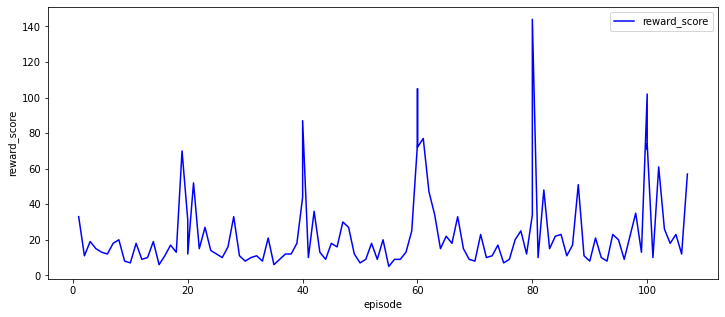

In [28]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
x_axis = "episode"
y_axis = "reward_score"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

### Explore output logs and videos

In [47]:
display(Markdown("Visit <a target=_blank href=\"https://s3.console.aws.amazon.com/s3/buckets/%s?region=%s&prefix=%s/&showversions=false\">the output logs, videos, and other artifacts in S3.</a>"%(s3_bucket,aws_region,s3_prefix)))

Visit <a target=_blank href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-us-east-1-011113936377?region=us-east-1&prefix=deepracer-notebook-sagemaker-221121-164133/&showversions=false">the output logs, videos, and other artifacts in S3.</a>

### Upload Your Model into the DeepRacer console

When training is complete, import the trained model into the DeepRacer console so one can clone and train it further in the console, evaluate it in the console, or submit it to the virtual league. Visit <a href="https://us-east-1.console.aws.amazon.com/deepracer/home?region=us-east-1#models">"Your Models"</a> in the DeepRacer console, click the 'Import model' button, and follow the directions. Use the following URL for your import path:

In [46]:
display(Markdown("Copy and paste this S3 path: <a target=_blank href=\"s3://%s/%s\">s3://%s/%s</a>"%(s3_bucket,s3_prefix,s3_bucket,s3_prefix)))

Copy and paste this S3 path: <a target=_blank href="s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133">s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133</a>

# Workshop Checkpoint #3

# Evaluation (Time trail, Object avoidance, Head to bot)

In [30]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "2022_reinvent_champ"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = s3_bucket
yaml_config["MODEL_S3_PREFIX"] = s3_prefix
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

JOB_TYPE                                : EVALUATION
WORLD_NAME                              : 2022_reinvent_champ
MODEL_S3_BUCKET                         : sagemaker-us-east-1-011113936377
MODEL_S3_PREFIX                         : deepracer-notebook-sagemaker-221121-164133
AWS_REGION                              : us-east-1
METRICS_S3_BUCKET                       : sagemaker-us-east-1-011113936377
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-221121-164133/evaluation_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-011113936377
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-221121-164133/iteration-data/evaluation
NUMBER_OF_TRIALS                        : 5
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 011113936377
CAR_COLOR                               : Grey
NUMBER_OF_RESETS                        : 10000
PENALTY_SECONDS                         : 2.0
IS_CONTINUOUS                           : false
OFF_TRACK_PENAL

#### Create the Kinesis video stream

In [31]:
kvs_stream_name=[]
kvs_stream_arns=[]
for job_no in range(num_simulation_workers):
    kvs_stream_name.append("dr-kvs-{}-{}".format(job_name,job_no))
    try:
        response=kinesisvideo.create_stream(StreamName=kvs_stream_name[job_no],MediaType="video/h264",DataRetentionInHours=24)
    except Exception as err:
        if err.__class__.__name__ == 'ResourceInUseException':
            response=kinesisvideo.describe_stream(StreamName=kvs_stream_name[job_no])["StreamInfo"]
        else:
            raise err
    print("Created kinesis video stream {}".format(kvs_stream_name[job_no]))
    kvs_stream_arns.append(response["StreamARN"])

Created kinesis video stream dr-kvs-deepracer-notebook-sagemaker-221121-164133-0


In [32]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "evaluation.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name[job_no],
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:011113936377:simulation-job/sim-4skwd86snh81


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

### Creating temporary folder top plot metrics

In [33]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

for job_no in range(num_simulation_workers):
    display(Markdown("View the Kinesis video stream <a target=_blank href=\"https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/%s\">here.</a> (Expand 'Media Playback')"%(kvs_stream_name[job_no])))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-4skwd86snh81)  

You can click on Gazebo after you open the above link to start the simulator.

View the Kinesis video stream <a href="https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/dr-kvs-deepracer-notebook-sagemaker-221121-164133-0">here.</a> (Expand 'Media Playback')

In [38]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df["elapsed_time"] = df["elapsed_time_in_milliseconds"] / 1000
df = df[["trial", "completion_percentage", "reset_count", "elapsed_time"]]

display(df)

Waiting for s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221121-164133/evaluation_metrics.json...


,trial,completion_percentage,reset_count,elapsed_time
0,1,100,11,35.181
1,2,100,21,41.348
2,3,100,15,38.402
3,4,100,23,41.989
4,5,100,16,38.208


### Explore output logs and videos

In [47]:
display(Markdown("Visit <a target=_blank href=\"https://s3.console.aws.amazon.com/s3/buckets/%s?region=%s&prefix=%s/&showversions=false\">the output logs, videos, and other artifacts in S3.</a>"%(s3_bucket,aws_region,s3_prefix)))

Visit <a target=_blank href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-us-east-1-011113936377?region=us-east-1&prefix=deepracer-notebook-sagemaker-221121-164133/&showversions=false">the output logs, videos, and other artifacts in S3.</a>

# Workshop Checkpoint #4

# Head-to-head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"

if not s3_prefix_2:
    raise Exception(
        "Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between"
    )

print("Using s3 bucket {}".format(s3_bucket_2))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket_2, s3_prefix_2
    )
)

In [ ]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "2022_reinvent_champ"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MODEL_S3_PREFIX"] = [s3_prefix, s3_prefix_2]
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = [
    "{}/model/model_metadata.json".format(s3_prefix),
    "{}/model/model_metadata.json".format(s3_prefix_2),
]
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["METRICS_S3_OBJECT_KEY"] = [
    "{}/evaluation_metrics.json".format(s3_prefix),
    "{}/evaluation_metrics.json".format(s3_prefix_2),
]
yaml_config["SIMTRACE_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["SIMTRACE_S3_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MP4_S3_OBJECT_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

#### Create the Kinesis video stream

In [19]:
kvs_stream_name=[]
kvs_stream_arns=[]
for job_no in range(num_simulation_workers):
    kvs_stream_name.append("dr-kvs-{}-{}".format(job_name,job_no))
    try:
        response=kinesisvideo.create_stream(StreamName=kvs_stream_name[job_no],MediaType="video/h264",DataRetentionInHours=24)
    except Exception as err:
        if err.__class__.__name__ == 'ResourceInUseException':
            response=kinesisvideo.describe_stream(StreamName=kvs_stream_name[job_no])["StreamInfo"]
        else:
            raise err
    print("Created kinesis video stream {}".format(kvs_stream_name[job_no]))
    kvs_stream_arns.append(response["StreamARN"])

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:011113936377:stream/dr-kvs-deepracer-notebook-sagemaker-221115-224306/1668552190446"
}
Created kinesis video stream dr-kvs-deepracer-notebook-sagemaker-221115-224306


In [ ]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "evaluation.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name[job_no],
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [38]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

for job_no in range(num_simulation_workers):
    display(Markdown("View the Kinesis video stream <a href=\"https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/%s\">here.</a> (Expand 'Media Playback')"%(kvs_stream_name[job_no])))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-15s9rn4f55t1)  

You can click on Gazebo after you open the above link to start the simulator.

View the Kinesis video stream <a href="https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/dr-kvs-deepracer-notebook-sagemaker-221118-032842-0">here.</a> (Expand 'Media Playback')

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_1 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_1["elapsed_time"] = df_1["elapsed_time_in_milliseconds"] / 1000
df_1 = df_1[["trial", "completion_percentage", "elapsed_time"]]

display(df_1)

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_2 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_2["elapsed_time"] = df_2["elapsed_time_in_milliseconds"] / 1000
df_2 = df_2[["trial", "completion_percentage", "elapsed_time"]]

display(df_2)

# Workshop Checkpoint #5

# Clean Up the Environment

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [60]:
# Cancelling robomaker job
for job_arn in job_arns:
    try:
        robomaker.cancel_simulation_job(job=job_arn)
    except:
        pass

# Stopping sagemaker training job
try:
    sage_session.sagemaker_client.stop_training_job(TrainingJobName=job_name)
except Exception as err:
    print("Could not stop training job; already stopped?",err)

Could not stop training job; already stopped? An error occurred (ValidationException) when calling the StopTrainingJob operation: The request was rejected because the training job is in status Stopped.


### Clean Up Simulation Application Resource

In [61]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '873a10b6-da28-414f-b06d-36a77d67523d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 18 Nov 2022 04:30:13 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '873a10b6-da28-414f-b06d-36a77d67523d',
   'access-control-allow-origin': '*',
   'access-control-allow-headers': 'Content-Type,X-Amz-Date,Authorization,X-Api-Key,X-Amz-Security-Token',
   'x-amz-apigw-id': 'bx6NVER-IAMF8MA=',
   'access-control-allow-methods': 'GET,OPTIONS,POST',
   'access-control-expose-headers': 'x-amzn-RequestId,x-amzn-ErrorType',
   'x-amzn-trace-id': 'Root=1-63770a55-5faa157a2d62eff74793d9f7'},
  'RetryAttempts': 0}}

### Remove Kinesis Video Streams

In [59]:
for streamarn in kvs_stream_arns:
    try:
        kinesisvideo.delete_stream(StreamARN=streamarn)
        print("Deleted",streamarn)
    except:
        pass

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
## Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}

#### Remove the docker images from Elastic Container Repository

In [76]:
ecr = boto3.client('ecr')

ecr.delete_repository(repositoryName=local_simapp_ecr_docker_image_name,force=True)
ecr.delete_repository(repositoryName=repository_short_name,force=True)

{'repository': {'repositoryArn': 'arn:aws:ecr:us-east-1:011113936377:repository/sagemaker-docker-cpu',
  'registryId': '011113936377',
  'repositoryName': 'sagemaker-docker-cpu',
  'repositoryUri': '011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu',
  'createdAt': datetime.datetime(2021, 11, 19, 18, 22, 41, tzinfo=tzlocal()),
  'imageTagMutability': 'MUTABLE'},
 'ResponseMetadata': {'RequestId': '8554e320-246f-4179-8db5-c6d7f2af8041',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8554e320-246f-4179-8db5-c6d7f2af8041',
   'date': 'Fri, 18 Nov 2022 05:14:09 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '310'},
  'RetryAttempts': 0}}

### Clean the docker images
Uncomment and run this only when you want to completely remove the docker containers or clean up the space of the sagemaker instance on this notebook.

In [6]:
#!docker rm -f $(docker ps -a -q);
#!docker rmi -f $(docker images -q);